### Problem Statement

#### Objectives
As a new hire to the ML Engineering team at CyberProtect, you have been entrusted with a critical task: protecting the users of CyberProtect from phishing attacks when they are assessing websites on the internet.

CyberProtect has collected a database of phishing websites and legitimate websites. CyberProtect’s data engineering team has extracted various features from these websites that may be helpful to your tasks. These features are described below in the “List of Attributes” section.

By leveraging these features, you will develop predictive models that can be installed as an extension and predict if a website is a phishing attack and warn the user before allowing the user to access it.

Specifically, your task is to build and evaluate prediction models, and also identify their respective key features of the dataset that categorise whether the website is a phishing attack. Your analysis should also include evaluation of which features contribute most significantly to phishing attack prediction.

In your submission, you are expected to build and evaluate at least three suitable models for this task and justify your choices based on the dataset provided.

#### Dataset
The dataset contains various features such as number of URL redirects, number of external references , which are gathered by the data engineering team to help your work. Specific information on the various dataset features shall be provided in the next page.

Important Note: The dataset contains synthetic or contaminated data. Therefore, you should state clearly any assumptions or justifications that you make in processing the data, including handling of outliers, missing values, and data quality issues.

You can query the dataset using the following URL:
https://techassessment.blob.core.windows.net/aiap22-assessment-data/phishing.db

#### List of Attributes
| Attribute           | Description                                               |
|---------------------|-----------------------------------------------------------|
| LineOfCode          | Number of lines of code                                  |
| LargestLineLength   | Longest line of code                                     |
| NoOfURLRedirect     | Number of URL redirects from the website                 |
| NoOfSelfRedirect    | Number of self-redirects from the website                |
| NoOfPopup           | Number of pop-ups from the website                       |
| NoOfiFrame          | Number of iFrames from the website                       |
| NoOfImage           | Number of images found in the website                    |
| NoOfSelfRef         | Number of clickable links within the same domain         |
| NoOfExternalRef     | Number of clickable links to external websites           |
| Robots              | Whether the website has a robots.txt                     |
| IsResponsive        | Whether the website adapts appropriately across devices  |
| Industry            | The industry the website belongs to                      |
| DomainAgeMonths     | Months since the domain was created                      |
| HostingProvider     | The hosting provider of the website                      |
| label               | 0 = phishing website, 1 = legitimate website             |

Theres an additional attribute not listed in the PDF: NoOfImages

### Library / Dependencies

In [1]:
# Data handling and graphics
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Analysis and Transformers
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency
#from collections import defaultdict
#from sklearn.preprocessing import OneHotEncoder,  StandardScaler , MinMaxScaler , LabelEncoder
#from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import mutual_info_classif # ,mutual_info_regression
#from sklearn.impute import KNNImputer

### Data Cleaning , Examination and Feature Engineering

#### Data Import

In [2]:
# Import Raw Data
# Connect to DB
conn = sqlite3.connect('data/phishing.db')
# Get list of all tables
table_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(table_query, conn)
# Load all tables into a dictionary of dataframes
dataframes = {}
for table_name in tables['name']:
    df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
    dataframes[table_name] = df
    print(f"Loaded table: {table_name}, shape: {df.shape}")

Loaded table: phishing_data, shape: (10500, 16)


In [3]:
# Querying the table
query = f"SELECT * FROM phishing_data"
df_raw = pd.read_sql_query(query, conn)
conn.close() # Good Practice to close
df_raw.head(10)

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label
0,0,NaN,9965,0,0,2,1,48,172,170,1,1,Fashion,DreamHost,98,0
1,1,769.0,9507,0,0,0,4,25,55,78,1,1,Fashion,AWS,31,1
2,2,720.0,2550,0,0,0,2,-31,94,13,0,1,Education,Google Cloud,26,1
3,3,198.0,869,0,0,0,0,0,0,2,0,0,Unknown,DreamHost,2,1
4,4,972.0,2807,0,0,0,2,6,83,51,0,1,Education,GoDaddy,43,1
5,5,247.0,4462,0,0,0,0,3,4,4,0,1,Manufacturing,AWS,8,1
6,6,2.0,80,0,0,0,0,0,0,0,0,0,Unknown,Freehostia,8,0
7,7,452.0,9381,0,0,0,0,2,36,42,1,1,Fashion,Bluehost,42,1
8,8,1018.0,9381,0,0,0,2,20,95,96,1,1,Manufacturing,Google Cloud,30,0
9,9,418.0,120391,0,0,0,3,2,0,2,1,0,eCommerce,DreamHost,2,0


In [4]:
# it is good practice to leave raw data untouched, so make a copy for analysis and revision
df_data = df_raw.copy()

#### Cursory Examination and exploration

In [5]:
# Quick examination of the data
df_data.nunique()

Unnamed: 0           10500
LineOfCode            2875
LargestLineLength     4027
NoOfURLRedirect          2
NoOfSelfRedirect         2
NoOfPopup               26
NoOfiFrame              48
NoOfImage              308
NoOfSelfRef            533
NoOfExternalRef        463
Robots                   2
IsResponsive             2
Industry                11
HostingProvider         13
DomainAgeMonths        121
label                    2
dtype: int64

In [6]:
# Quick examination of null values and dtypes
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         10500 non-null  int64  
 1   LineOfCode         8145 non-null   float64
 2   LargestLineLength  10500 non-null  int64  
 3   NoOfURLRedirect    10500 non-null  int64  
 4   NoOfSelfRedirect   10500 non-null  int64  
 5   NoOfPopup          10500 non-null  int64  
 6   NoOfiFrame         10500 non-null  int64  
 7   NoOfImage          10500 non-null  int64  
 8   NoOfSelfRef        10500 non-null  int64  
 9   NoOfExternalRef    10500 non-null  int64  
 10  Robots             10500 non-null  int64  
 11  IsResponsive       10500 non-null  int64  
 12  Industry           10500 non-null  object 
 13  HostingProvider    10500 non-null  object 
 14  DomainAgeMonths    10500 non-null  int64  
 15  label              10500 non-null  int64  
dtypes: float64(1), int64(1

#### Duplicate data in the set

In [7]:
# Checking Duplciates
df_duplicated = df_data[df_data.duplicated(keep=False)]
df_duplicated.nunique()

Unnamed: 0           0
LineOfCode           0
LargestLineLength    0
NoOfURLRedirect      0
NoOfSelfRedirect     0
NoOfPopup            0
NoOfiFrame           0
NoOfImage            0
NoOfSelfRef          0
NoOfExternalRef      0
Robots               0
IsResponsive         0
Industry             0
HostingProvider      0
DomainAgeMonths      0
label                0
dtype: int64

In [8]:
# Examining missing hosting providers
df_duplicated['HostingProvider'].unique()

array([], dtype=object)

`NoOfURLRedirect`, `NoOfSelfRedirect`, `NoOfPopup` all have the same outputs.  
Azure, Godaddy, AWS, Google Cloud are not amongst the hosts.  
Duplicates in a cybersecurity setting might represent attack signals from a similar source.  
Data cleaning of duplicates will remove this signal.  
Further assessment will be done at or after feature engineering to transform these into signals  

##### Cursory Assessment  
Null values for `LineOfCode`. The dtype should be int instead of float.  
string cleaning might be needed for object dtypes.  
Unamed: 0 appears to be another index and can be dropped.  
There is a attribute not listed in the initial table `NoOfImage`, it as been added post assessment.

#### Dropping ghost-index `Unnamed: 0`

In [9]:
# Checking for unique counts
df_data['Unnamed: 0'].nunique() == len(df_data)

True

In [10]:
# checking for Total value difference
(df_data['Unnamed: 0'] - df_data.index).abs().sum()

np.int64(0)

In [11]:
# dropping the column
df_data = df_data.drop(columns=['Unnamed: 0'])

In [12]:
# Quick Confirmation
df_data.head()

,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label
0,NaN,9965,0,0,2,1,48,172,170,1,1,Fashion,DreamHost,98,0
1,769.0,9507,0,0,0,4,25,55,78,1,1,Fashion,AWS,31,1
2,720.0,2550,0,0,0,2,-31,94,13,0,1,Education,Google Cloud,26,1
3,198.0,869,0,0,0,0,0,0,2,0,0,Unknown,DreamHost,2,1
4,972.0,2807,0,0,0,2,6,83,51,0,1,Education,GoDaddy,43,1


#### Rename`IsResponsive` to `is_responsive` 

In [13]:
# Renaming to follow schema / naming convention
df_data.rename(columns={"IsResponsive": "is_responsive"}, inplace=True)

#### Rename`Robots` to `has_robotstxt` and Examination

In [14]:
# Renaming to make feature name more intuitive
df_data.rename(columns={"Robots": "has_robotstxt"}, inplace=True)

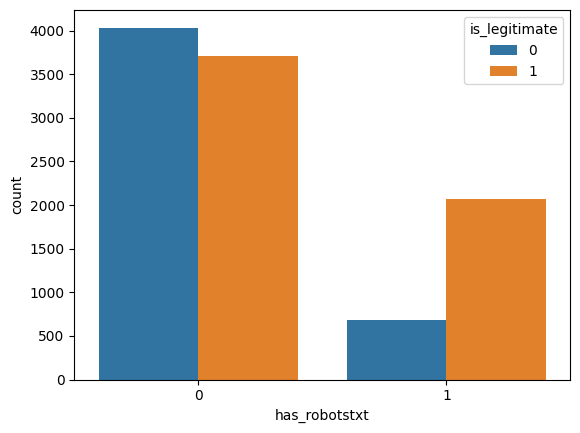

In [56]:
# Quick Examination
sns.countplot(x='has_robotstxt', data=df_data, hue='is_legitimate')
plt.show()

Feature looks appopriate, there looks like a slight class imbalance for samples with a robot.txt but we will re-examine after modeling

#### Rename `label` to `is_legitimate`

In [15]:
# Renaming to make features's purpose clearer
df_data.rename(columns={"label": "is_legitimate"}, inplace=True)

#### String cleaning for `Industry` and `HostingProvider`

In [16]:
df_data['Industry'].unique()

array(['Fashion', 'Education', 'Unknown', 'Manufacturing', 'eCommerce ',
       'Non-profit', 'Food', 'Government', 'eCommerce', 'Banking',
       'Healthcare'], dtype=object)

There is a duplicate for `eCommerce` and `eCommerce `, a trailing whitespace.  
We can clean it anyway and query the maintainer for the scrapper for answers why there is this discrepancy.  
I will run a chi-square test just to check if there are any meaningful differences  

In [17]:
# Select the two raw groups
mask = df_data['Industry'].isin(['eCommerce', 'eCommerce '])
subset = df_data[mask].copy()

# Contingency table between industry variant and the target label
table = pd.crosstab(subset['Industry'], subset['is_legitimate'])

# Run chi-square test
chi2, p, dof, expected = chi2_contingency(table)

print("Contingency Table:\n", table)
print("\nChi-square p-value:", p)

Contingency Table:
 is_legitimate     0     1
Industry                 
eCommerce      1371  1150
eCommerce       253   191

Chi-square p-value: 0.3356453330634346


Whitespace variants are not significantly different from each other (χ² p = 0.3356), therefore cleaning and merging them is statistically justified.

In [18]:
df_data['HostingProvider'].unique()

array(['DreamHost', 'AWS', 'Google Cloud', 'GoDaddy', 'Freehostia',
       'Bluehost', 'Unknown Provider', 'Hostinger', 'Namecheap',
       'InfinityFree', '000webhost', 'Azure', 'HostGator'], dtype=object)

No discrepancies noted.

In [19]:
# Basic cleaning of strings
for col in df_data.select_dtypes(include=['object', 'string']):
        df_data[col] = (
            df_data[col]
            .str.lower()                            # Converts text to lowercase
            .str.strip()                            # Strip leading/trailing whitespace
            .str.replace(r'\s+', '', regex=True)    # Remove all whitespace (including between words)
            .str.replace('_', '', regex=False)      # Remove all underscores
            .str.replace('.', '', regex=False)      # Remove all periods
        )
# Most of this is unnecessary for this dataset considering we only need to strip trailing whitespace for `eCommerce `
# but we do this in case other datasets would require more robust cleaning to intergrate.

#### Examining Numerical features

My usual templates fail to visual the features well so im doing it one by one.

##### Examining `LineOfCode` and log scaling

In [20]:
# Checking if there are fractional values as dtype is float (there shouldnt be)
df_fractional = df_data[df_data['LineOfCode'] % 1 != 0].copy()
df_fractional['LineOfCode'].sum()

np.float64(0.0)

All data is discrete integers. The dtype is incorrect and might pose an issue in the future (resolved as we transform into log further down)

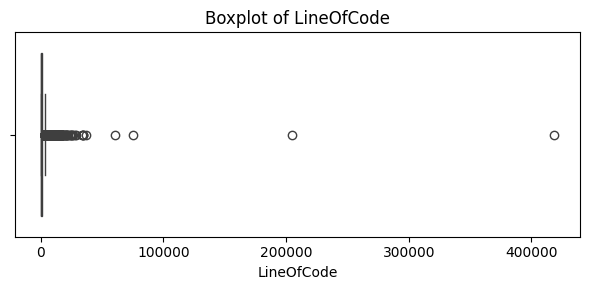

In [21]:
# Displaying a simple plot
plt.figure(figsize=(6, 3))
sns.boxplot(x=df_data['LineOfCode'])
plt.title("Boxplot of LineOfCode")
plt.xlabel("LineOfCode")
plt.tight_layout()
plt.show()

There are severe right tailed outliers.

In [22]:
# Examining the right tail/ Outlier Threshold
df_data['LineOfCode'].describe(percentiles=[0.90, 0.95, 0.98, 0.99])

count      8145.000000
mean       1376.952363
std        5751.557001
min           2.000000
50%         620.000000
90%        3055.200000
95%        4911.200000
98%        8287.920000
99%       11412.880000
max      418650.000000
Name: LineOfCode, dtype: float64

In [23]:
# Examining upper percentiles
q98 = df_data['LineOfCode'].quantile(0.98)
df_outliers = df_data[df_data['LineOfCode'] > q98].copy()
df_outliers.sort_values('LineOfCode', ascending=False, inplace=True)

df_outliers.head(20)

,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,has_robotstxt,is_responsive,Industry,HostingProvider,DomainAgeMonths,is_legitimate
10157,418650.0,20750,0,0,0,0,667,485,65,0,1,ecommerce,unknownprovider,100,1
1583,205162.0,2584,0,0,0,0,284,26596,80,0,1,ecommerce,azure,32,1
5575,75064.0,1437,0,0,0,0,1906,35,1917,0,0,non-profit,unknownprovider,71,1
651,61048.0,4612,0,0,6,7,37,4071,4142,0,0,ecommerce,godaddy,44,0
6401,37076.0,4812,0,0,10,14,36,11863,11901,0,0,fashion,aws,17,1
4695,34778.0,14399,0,0,0,19,199,229,16,0,1,ecommerce,dreamhost,75,1
4364,34444.0,3944,0,0,0,19,2260,519,228,0,1,healthcare,hostinger,81,1
7778,34382.0,39008,0,0,0,21,853,319,26,0,1,ecommerce,unknownprovider,103,1
706,33848.0,4379,0,0,564,10,1112,1253,1707,0,1,non-profit,bluehost,55,1
6147,28939.0,18733,0,0,0,2,602,2745,2657,0,1,ecommerce,googlecloud,8,1


The distribution is heavy-tailed, right-skewed.  
Suspect that winsorizing the upper percentiles will lose potential signal 
I will log transform (natural log).  

Not using log(1+n) as The minimum in the set is 2 and we should not expect 0 or 1.  
A warning/exception will be set in the final cleaning file to pick up on lines of code containing less than 2 lines. Just in case.  

In [24]:
# Log transform
df_data['LineOfCode_log'] = np.log(df_data['LineOfCode'])

In [25]:
# Dropping old column
df_data.drop(columns=['LineOfCode'], inplace=True)

##### Examining `LineOfCode_log`'s NaN values, Creating Binary flag

In [26]:
# Examining number of NaN Values
df_data['LineOfCode_log'].isna().sum()

np.int64(2355)

These values constitute 22.4% of the dataset and constitutes a large part of the set. It cannot be dropped. without harm

In [27]:
# Sepearting Nan from Non-Nans to see if theres a distinction
df_nan = df_data[df_data['LineOfCode_log'].isna()]
df_non = df_data[df_data['LineOfCode_log'].notna()]

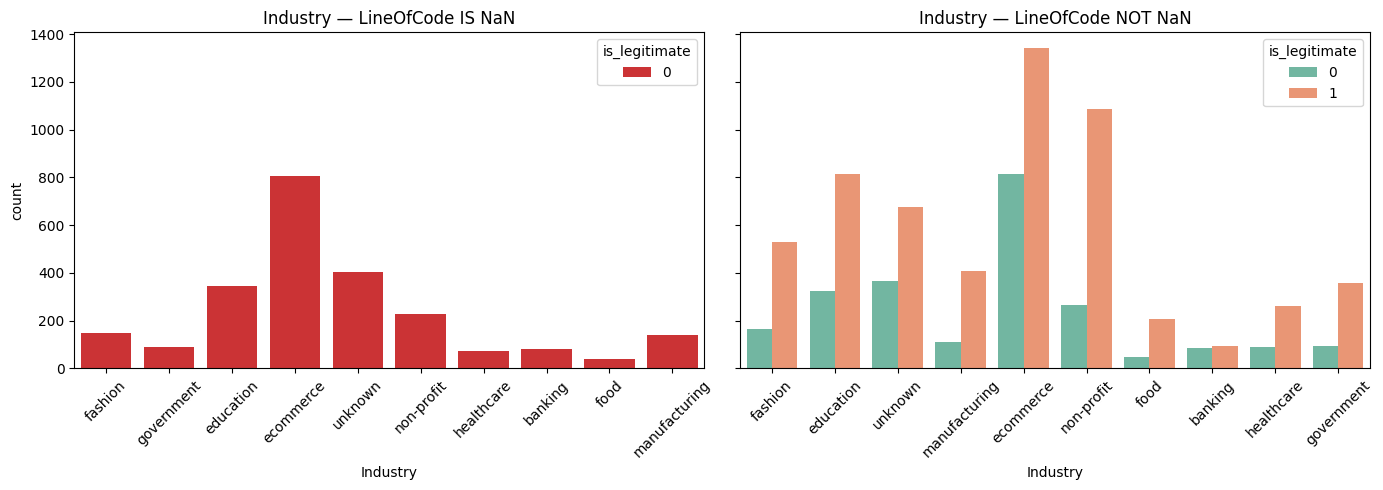

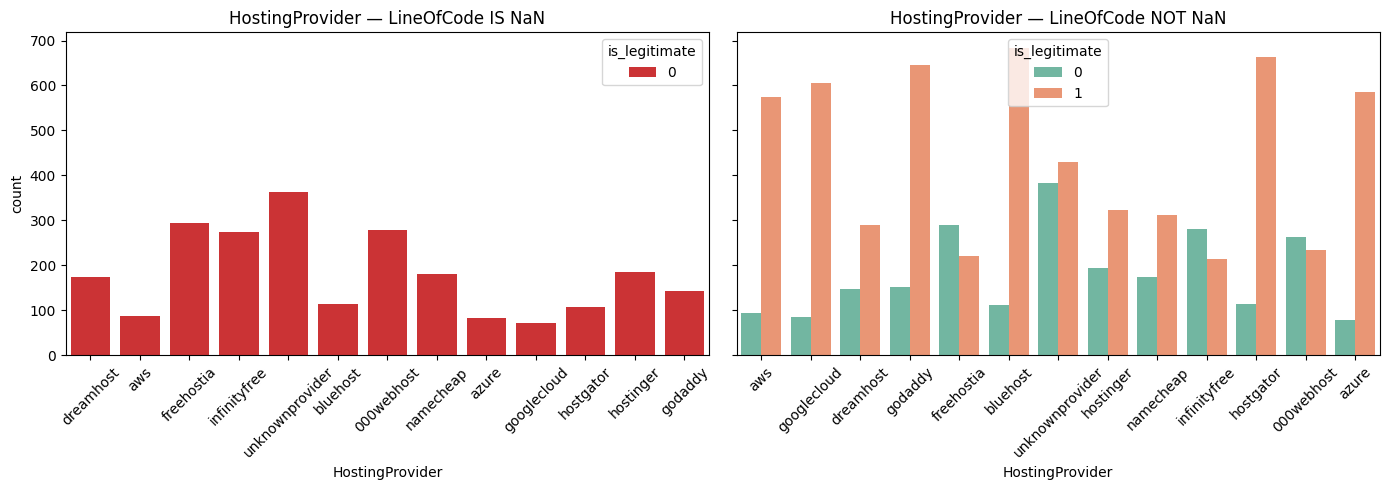

In [28]:
# Plotting both populations against categorical features
cat_features = df_data.select_dtypes(include=['object']).columns.tolist()
cat_features = [c for c in cat_features if c not in ['LineOfCode_log']]

for col in cat_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Left: NaN group
    sns.countplot(
        data=df_nan,
        x=col,
        hue='is_legitimate',
        ax=axes[0],
        palette='Set1'
    )
    axes[0].set_title(f"{col} — LineOfCode IS NaN")
    axes[0].tick_params(axis='x', rotation=45)

    # Right: Non-NaN group
    sns.countplot(
        data=df_non,
        x=col,
        hue='is_legitimate',
        ax=axes[1],
        palette='Set2'
    )
    axes[1].set_title(f"{col} — LineOfCode NOT NaN")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

odd, theres a clear signal, NaNs appear to be all illegitimate sites

In [29]:
# Double Checking if all Nan values are phishing sites
df_nan['is_legitimate'].value_counts()

is_legitimate
0    2355
Name: count, dtype: int64

All NaN values belong to phishing sites.  
We cannot clean this as this represents a signal.

In [30]:
# Creating a Binary flag for NaN Values
df_data['LineOfCode_NaN'] = df_data['LineOfCode_log'].isna().astype(int)

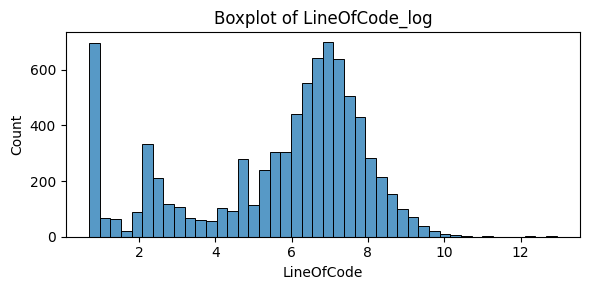

In [31]:
# Re-examining LineOfCode_log
plt.figure(figsize=(6, 3))
sns.histplot(x=df_data['LineOfCode_log'])
plt.title("Boxplot of LineOfCode_log")
plt.xlabel("LineOfCode")
plt.tight_layout()
plt.show()

A very multi-modal distribution, will take into account to not use models assuming gaussian distributions  
There are also very distinct niches near 0 , 2 ,5 tthen the main distribution.  
This makes it more attractive to bin the values along with NaNs

Otherwise we will have to impute NaNs to a out of scale value to keep their signal, -1 or 2 std from min.

Since there can be 2 approaches to this, we can do both and internally validate them during testing. 
To summarise, these are the 2 methods
- Discretization (binning)
- Imputation with a Sentinel Value.

##### Examining `LargestLineLength` and log scaling

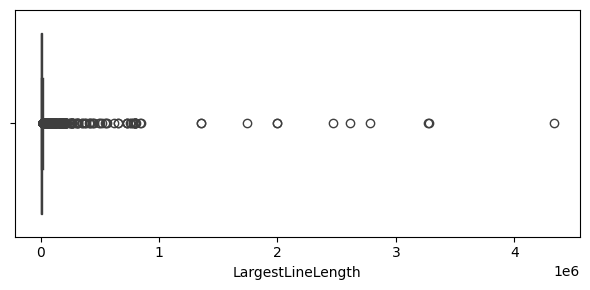

In [32]:
# Displaying a simple plot
plt.figure(figsize=(6, 3))
sns.boxplot(x=df_data['LargestLineLength'])
plt.tight_layout()
plt.show()

In [33]:
# Examining the right tail/ Outlier Threshold
df_data['LargestLineLength'].describe(percentiles=[0.90, 0.95, 0.98, 0.99])

count    1.050000e+04
mean     1.119796e+04
std      9.416898e+04
min      2.200000e+01
50%      1.087500e+03
90%      1.418560e+04
95%      2.649060e+04
98%      5.642142e+04
99%      1.294878e+05
max      4.336498e+06
Name: LargestLineLength, dtype: float64

Seems to be the same situation with `LineOfCode` 

In [34]:
# Log scaling
df_data['LargestLineLength_log'] = np.log(df_data['LargestLineLength'])

In [35]:
# We dont need the original data (raw data is still preserved)
df_data.drop(columns=['LargestLineLength'], inplace=True)

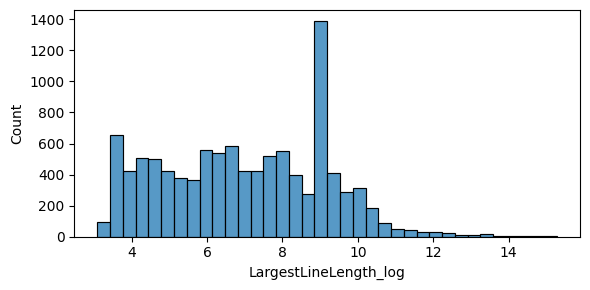

In [36]:
# Displaying a simple plot
plt.figure(figsize=(6, 3))
sns.histplot(x=df_data['LargestLineLength_log'])
plt.tight_layout()
plt.show()

Usual mode but most models should be able to handle this

##### Examining `NoOfURLRedirect` and `NoOfSelfRedirect`

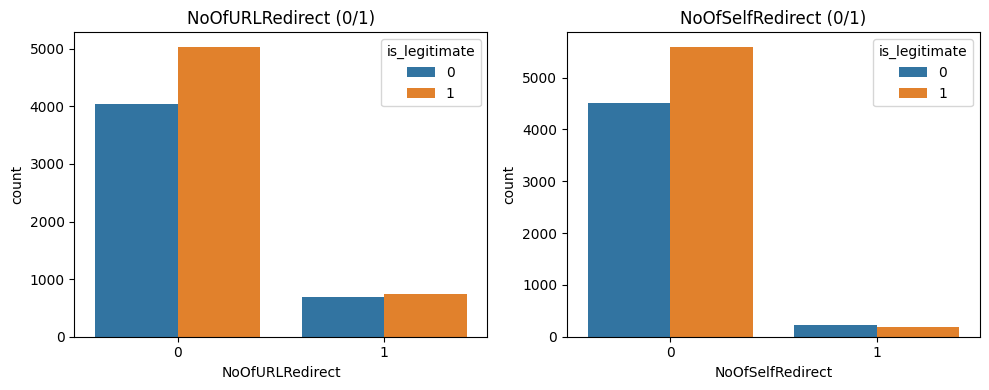

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x='NoOfURLRedirect', data=df_data, hue='is_legitimate', ax=axes[0])
axes[0].set_title('NoOfURLRedirect (0/1)')

sns.countplot(x='NoOfSelfRedirect', data=df_data, hue='is_legitimate',ax=axes[1])
axes[1].set_title('NoOfSelfRedirect (0/1)')

plt.tight_layout()
plt.show()

Nothing out of the ordinary, but naming suggests multiple counts other than one resembling a binary flag. Might be a mislabel. Will process during feature engineering

##### Examining `NoOfPopup`, Winsorise/clip to 31

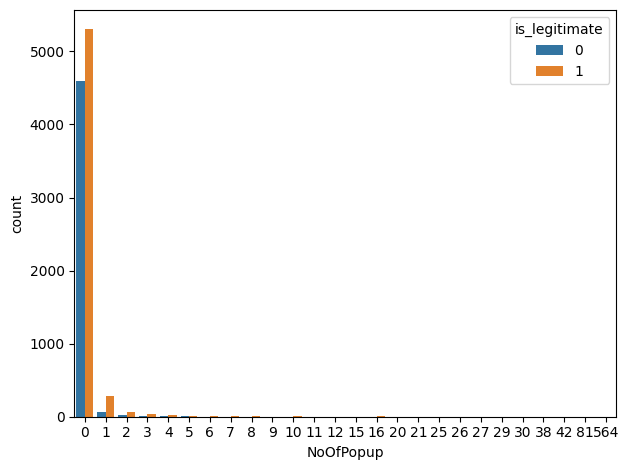

In [59]:
# Basic Examination
sns.countplot(x='NoOfPopup', data=df_data, hue='is_legitimate')
plt.tight_layout()
plt.show()

In [63]:
# Examining the upper percentiles
df_data['NoOfPopup'].describe(percentiles=[0.90, 0.95, 0.98, 0.99])

count    10500.000000
mean         0.227524
std          5.700292
min          0.000000
50%          0.000000
90%          0.000000
95%          1.000000
98%          2.000000
99%          4.000000
max        564.000000
Name: NoOfPopup, dtype: float64

In [66]:
# Looking at the head
df_data.sort_values(by='NoOfPopup', ascending=False).head(10)

,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,has_robotstxt,is_responsive,Industry,HostingProvider,DomainAgeMonths,is_legitimate,LineOfCode_log,LineOfCode_NaN,LargestLineLength_log,HasSelfRef,HasExternalRef,SelfRef_log1p,ExternalRef_log1p,HasURLRedirect,HasSelfRedirect
706,0,0,564,10,1112,0,1,non-profit,bluehost,55,1,10.429635,0,8.384576,1,1,7.134094,7.443078,0,0
9384,0,0,81,0,85,0,1,education,azure,24,1,6.941190,0,7.109879,1,1,2.890372,3.295837,0,0
10023,1,0,42,7,52,1,1,ecommerce,azure,26,1,8.132119,0,9.372289,1,1,4.859812,5.303305,1,0
6028,0,0,38,0,22,0,0,education,dreamhost,114,1,7.363280,0,6.898715,1,1,4.691348,3.135494,0,0
2627,0,0,30,0,38,1,1,unknown,godaddy,50,0,6.190315,0,7.778630,1,1,4.672829,4.753590,0,0
334,0,0,30,0,49,1,1,non-profit,godaddy,58,0,7.128496,0,9.560997,1,1,4.844187,4.882802,0,0
1325,0,0,29,11,61,0,0,food,bluehost,57,1,8.495970,0,10.375770,1,1,4.762174,5.170484,0,0
2985,1,0,27,2,342,1,1,fashion,aws,32,1,8.396606,0,8.146709,1,1,5.700444,5.888878,1,0
3553,1,1,26,1,52,1,1,banking,googlecloud,13,1,7.797702,0,10.432467,1,1,6.109248,3.931826,1,1
5241,0,0,26,0,4,1,0,healthcare,hostgator,52,1,6.182085,0,7.568379,1,1,1.386294,3.496508,0,0


illegitimate site's highest popup count is 38. all above that are legitimate.
I could possibly cap the number at 39 and perserve the signal of 3 samples

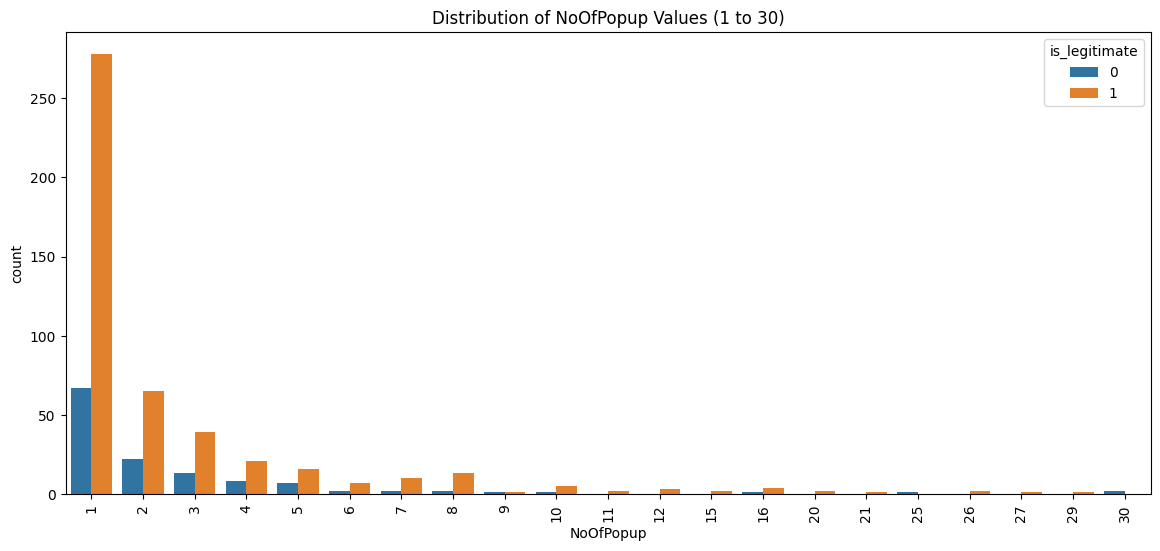

In [68]:
# Exampling population from 1-30
subset = df_data[(df_data['NoOfPopup'] >= 1) & (df_data['NoOfPopup'] <= 30)]

plt.figure(figsize=(14, 6))
sns.countplot(data=subset, x='NoOfPopup', hue='is_legitimate')
plt.title("Distribution of NoOfPopup Values (1 to 30)")
plt.xticks(rotation=90)
plt.show()

there is not enough stable local densities to consider binning values.

In [69]:
# Capping values to 31
df_data['NoOfPopup'] = df_data['NoOfPopup'].clip(upper=31)

##### Examining `NoOfiFrame`, binary flag and log1p transform

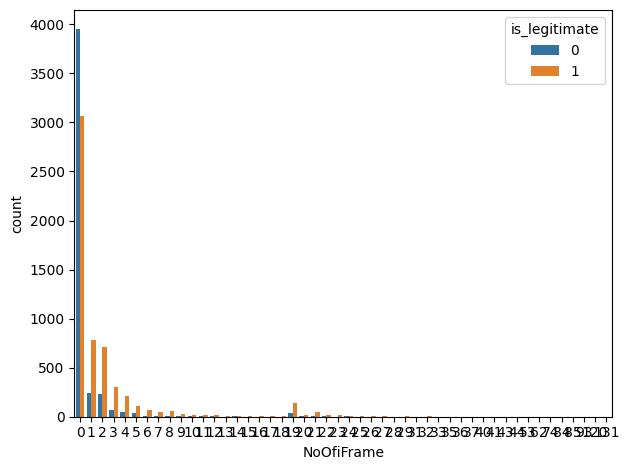

In [70]:
# Basic Examination
sns.countplot(x='NoOfiFrame', data=df_data, hue='is_legitimate')
plt.tight_layout()
plt.show()

In [71]:
# Examining the upper percentiles
df_data['NoOfiFrame'].describe(percentiles=[0.90, 0.95, 0.98, 0.99])

count    10500.000000
mean         1.668381
std          5.016302
min          0.000000
50%          0.000000
90%          4.000000
95%          9.000000
98%         19.000000
99%         21.000000
max        131.000000
Name: NoOfiFrame, dtype: float64

In [77]:
# Looking at the head
df_data.sort_values(by='NoOfiFrame', ascending=False).head(20)

,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,has_robotstxt,is_responsive,Industry,HostingProvider,DomainAgeMonths,is_legitimate,LineOfCode_log,LineOfCode_NaN,LargestLineLength_log,HasSelfRef,HasExternalRef,SelfRef_log1p,ExternalRef_log1p,HasURLRedirect,HasSelfRedirect
333,0,0,0,131,262,0,1,fashion,godaddy,40,0,NaN,1,8.080547,1,1,6.146329,4.204693,0,0
2134,0,0,0,120,140,0,1,education,godaddy,77,1,7.734996,0,6.562444,1,1,1.098612,5.236442,0,0
7986,1,1,0,93,409,0,1,fashion,unknownprovider,76,0,8.799662,0,7.021084,1,1,1.386294,6.335054,1,1
4406,1,1,0,93,409,0,1,fashion,unknownprovider,119,1,8.799662,0,7.021084,1,1,1.386294,6.335054,1,1
7938,1,0,1,85,90,0,1,non-profit,googlecloud,21,0,9.967260,0,6.131226,1,1,5.361292,4.262680,1,0
4127,1,0,1,84,89,0,1,education,godaddy,56,0,9.956697,0,6.184149,1,1,5.384495,3.583519,1,0
9989,0,0,20,74,115,0,0,education,freehostia,95,1,7.454141,0,7.989221,1,1,5.225747,4.317488,0,0
2804,0,0,0,62,51,1,1,fashion,azure,10,1,7.875499,0,9.002578,1,1,5.953243,5.883322,0,0
3730,0,0,0,62,51,1,1,fashion,azure,7,1,7.875499,0,9.002578,1,1,5.953243,5.883322,0,0
2290,1,0,0,53,140,0,1,ecommerce,aws,34,1,9.057306,0,10.345510,1,1,4.836282,3.828641,1,0


In [86]:
# Binary flag and log1p transform
df_data['HasIframe'] = (df_data['NoOfiFrame'] > 0).astype(int)
df_data['NoOfiFrame_log'] = np.log1p(df['NoOfiFrame'])

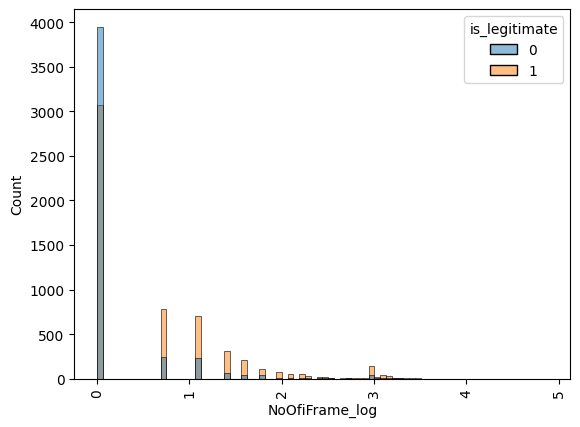

In [89]:
# Exampling population from 
sns.histplot(df_data, x='NoOfiFrame_log', hue='is_legitimate')
plt.xticks(rotation=90)
plt.show()

Heuristically looks sufficient

##### Examining `NoOfImage`

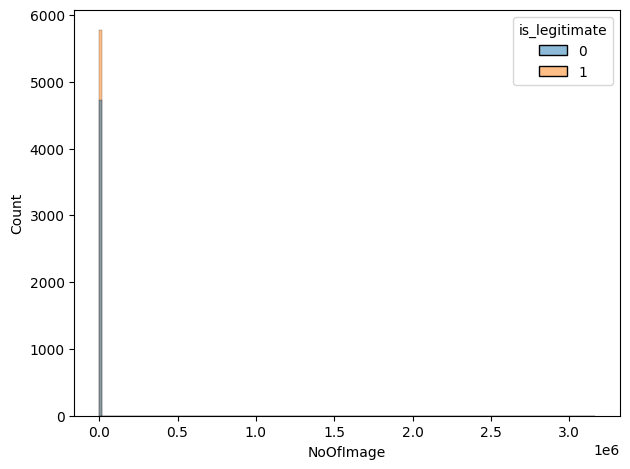

In [91]:
# Basic Examination
sns.histplot(x='NoOfImage', data=df_data, hue='is_legitimate')
plt.tight_layout()
plt.show()

In [94]:
df_data['NoOfImage'].describe(percentiles=[0.90, 0.95, 0.98, 0.99])

count    1.050000e+04
mean     3.252675e+02
std      3.089686e+04
min     -3.500000e+01
50%      5.000000e+00
90%      6.000000e+01
95%      9.100000e+01
98%      1.680200e+02
99%      2.500500e+02
max      3.166000e+06
Name: NoOfImage, dtype: float64

In [96]:
# Examining negative entries
# Ensure numeric conversion (in case of stray strings)
col = pd.to_numeric(df_data['NoOfImage'], errors='coerce')

# Select rows where the value is negative
df_negative = df_data[col < 0].copy()

print("Number of negative entries:", len(df_negative))
print(df_negative['NoOfImage'].describe())

# Preview the rows
df_negative[['NoOfImage']].head(20)


Number of negative entries: 377
count    377.00000
mean     -32.98939
std        1.42914
min      -35.00000
25%      -34.00000
50%      -33.00000
75%      -32.00000
max      -31.00000
Name: NoOfImage, dtype: float64


,NoOfImage
2,-31
34,-31
44,-34
58,-34
67,-31
127,-35
131,-32
134,-31
151,-32
155,-32


377 samples or 3.59% of the set is contaminated with a negative flag. The values seem to be isolated to -35 to -31.
We can test to see whether its just a flag flip against 31-35

In [97]:
# Convert to numeric just in case
col = pd.to_numeric(df_data['NoOfImage'], errors='coerce')

# Negative band: -35 to -31
df_neg_band = df_data[col.between(-35, -31)]

# Positive mirror band: 31 to 35
df_pos_band = df_data[col.between(31, 35)]

print("Negative samples:", df_neg_band.shape[0])
print("Positive samples:", df_pos_band.shape[0])

# Take a sample (or full set if you want)
df_pos_sample = df_pos_band.sample(
    n=min(len(df_pos_band), len(df_neg_band)),   # matched size
    random_state=42
)
df_pos_sample.head()

Negative samples: 377
Positive samples: 0


,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,has_robotstxt,is_responsive,Industry,HostingProvider,DomainAgeMonths,...,LineOfCode_NaN,LargestLineLength_log,HasSelfRef,HasExternalRef,SelfRef_log1p,ExternalRef_log1p,HasURLRedirect,HasSelfRedirect,HasIframe,NoOfiFrame_log


Internal validation candidate

##### Examining `NoOfSelfRef` and `NoOfExternalRef`

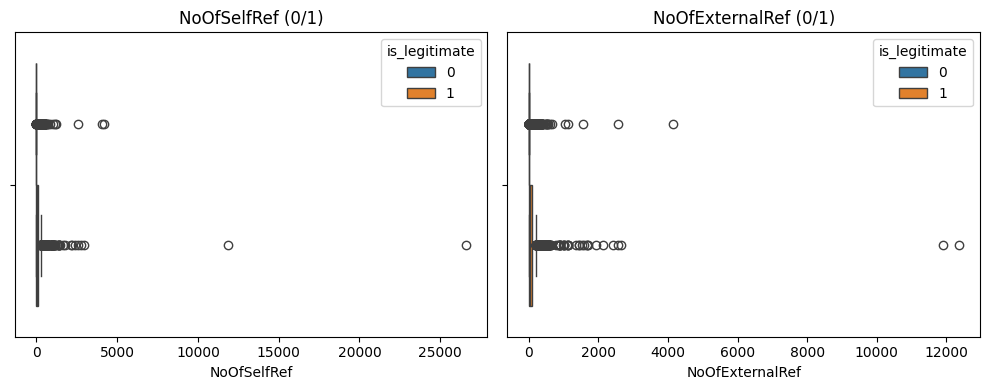

In [39]:
# Plotting to see distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(x='NoOfSelfRef', data=df_data, hue='is_legitimate', ax=axes[0])
axes[0].set_title('NoOfSelfRef (0/1)')

sns.boxplot(x='NoOfExternalRef', data=df_data, hue='is_legitimate',ax=axes[1])
axes[1].set_title('NoOfExternalRef (0/1)')

plt.tight_layout()
plt.show()

In [40]:
#Further Examination of NoOfSelfRef
df_data['NoOfSelfRef'].describe(percentiles=[0.90, 0.95, 0.98, 0.99])

count    10500.00000
mean        68.54219
std        316.67927
min          0.00000
50%         12.00000
90%        175.00000
95%        255.00000
98%        385.04000
99%        514.02000
max      26596.00000
Name: NoOfSelfRef, dtype: float64

In [41]:
#Further Examination of NoOfExternalRef
df_data['NoOfExternalRef'].describe(percentiles=[0.90, 0.95, 0.98, 0.99])

count    10500.000000
mean        51.152476
std        204.902781
min          0.000000
50%         10.000000
90%        138.100000
95%        207.050000
98%        315.000000
99%        423.010000
max      12353.000000
Name: NoOfExternalRef, dtype: float64

I cannot traditionally log scale this appopriately when there are values = 0 and majority values being this small.
Will capture the presence using a binary flag then log1p scale the feature

In [42]:
# Create new features, binary flags
df_data['HasSelfRef'] = (df_data['NoOfSelfRef'] > 0).astype(int)
df_data['HasExternalRef'] = (df_data['NoOfExternalRef'] > 0).astype(int)

In [43]:
# Log1p scaling
df_data['SelfRef_log1p'] = np.log1p(df_data['NoOfSelfRef'])
df_data['ExternalRef_log1p'] = np.log1p(df_data['NoOfExternalRef'])

In [44]:
# Dropping raw columns (they are still preserved in df_raw)
df_data.drop(columns=['NoOfSelfRef'], inplace=True)
df_data.drop(columns=['NoOfExternalRef'], inplace=True)

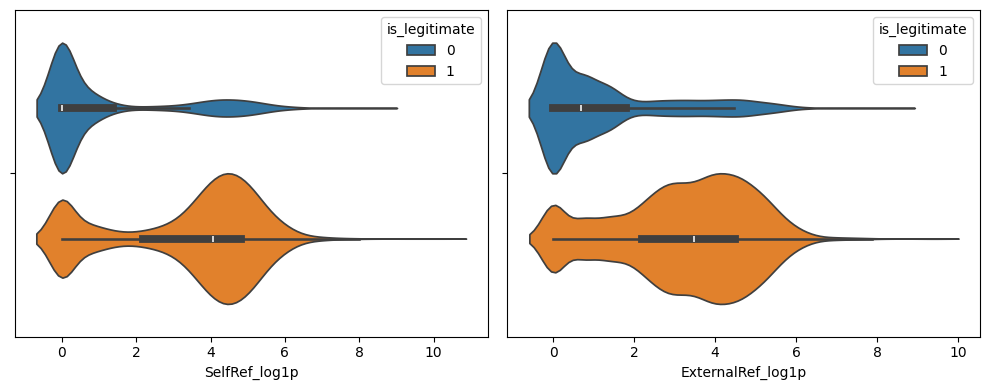

In [45]:
# Re-Examining the distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.violinplot(x='SelfRef_log1p', data=df_data, hue='is_legitimate', ax=axes[0])
sns.violinplot(x='ExternalRef_log1p', data=df_data, hue='is_legitimate',ax=axes[1])

plt.tight_layout()
plt.show()

Looks ready for input distribution wise

#### Examining `is_responsive` and `Industry`

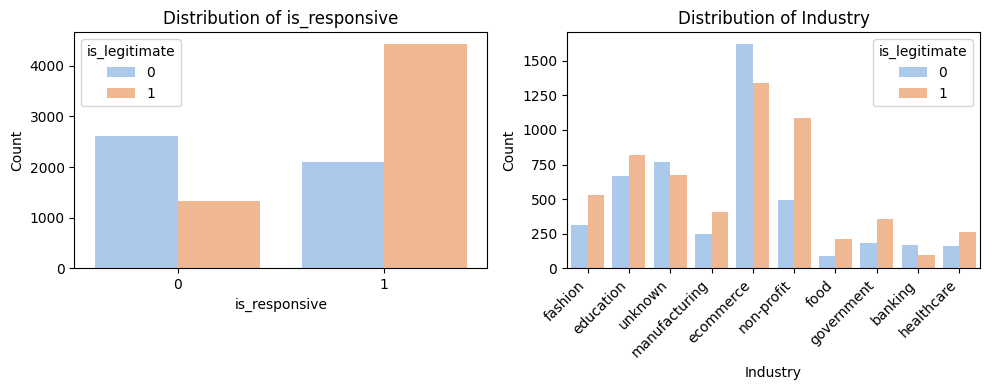

In [100]:
# plot
plt.figure(figsize=(10, 4))

for i, col in enumerate(["is_responsive", "Industry"], start=1):
    plt.subplot(1, 2, i)
    sns.countplot(
        data=df_data,
        x=col,
        palette="pastel",
        hue='is_legitimate'
    )
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Sites are generally more legitimate count wise for all industries except for ecommerce, banking and unknown?
Because it has a distinct distribution it would be unwise to examine it further and clarify with the scraper, it is likely to carry signals that might be useful when identified.

there is no great class imbalance besides maybe a slight to food and non profit. Resampling should not be required.

### Domain Research

#### Feature relation to phishing

A rough understanding of the attributes/features will help with effective feature engineering

| Attribute           | Description                                               | Possible Attack Vector / Threat Signal                                   |
|---------------------|-----------------------------------------------------------|---------------------------------------------------------------------------|
| LineOfCode          | Number of lines in the HTML/JS/CSS source                | Very small codebases may indicate *single-page phishing kits*; extremely long minified lines can hide *obfuscated payloads*. |
| LargestLineLength   | Length of the longest line of source                     | Long single-line JS often used for *obfuscation*, *malicious script injection*, or *form hijacking*. |
| NoOfURLRedirect     | Total number of HTTP redirects                           | *Redirect chains* used to hide malicious origins, rotate landing pages, track victims, or evade detection. |
| NoOfSelfRedirect    | Redirects back to same domain                            | Masked redirection surfaces; can support *open redirect setups* or hide spoofed URLs. |
| NoOfPopup           | Count of pop-up windows                                 | Used in *fake alerts*, *support scams*, credential prompts, or pressure-inducing dialogs. |
| NoOfiFrame          | Count of iframe elements                                 | Iframes can host *cloaked phishing pages*, *credential-stealing forms*, or *drive-by scripts*. |
| NoOfImage           | Number of Images found in the website                   | Excessive or stolen brand images; hidden tracking pixels; image-based phishing layouts |
| NoOfSelfRef         | Internal links within same domain                        | Low internal structure suggests *throwaway phishing pages* with no real site architecture. |
| NoOfExternalRef     | Outbound links to other domains                          | Few/no external links may indicate isolation typical of *phishing kits*; unusual external links may hide *malicious third-party scripts*. |
| has_robotstxt            | Presence of `robots.txt`                                 | Lack of robots.txt common in *temporary malicious domains* that avoid SEO and indexing. |
| is_responsive        | Whether layout adapts across devices                     | Broken mobile responsiveness typical of *template-based phishing kits* not optimised for real use. |
| Industry            | Inferred industry of site                                | Attackers often mimic *finance*, *government*, *healthcare* for targeted credential harvesting. |
| DomainAgeMonths     | Age of domain                                            | Very new domains strongly tied to *domain churn*, common in phishing and malware delivery. |
| HostingProvider     | Hosting provider name                                    | Bulletproof or low-reputation hosts associated with *malware hosting* or *phishing kits*. |
| is_legitimate               | Ground truth: 0 = phishing, 1 = legitimate               | — |



#### `has_robotstxt`'s influence on other statistics and `LineOfCode`'s NaN values

The presence of a robot.txt's ability to scrape data is a guideline at most, We do not know if the scraper is respecting the Robots Exclusion Protocol (REP).  
The site's agent can still deny scraping via rate limiting or blocking if it is detected.  
There are no features that indicate this, meaning for every row of data, we do not know if it is a full index.  



### Exploratory Tests

#### Exploring Linear Relationships, Pearson's Correlation

#### Exploring Monotonic Relationships, Spearman's Correlation

#### Exploring Mutual Information 

#### Exploring Distributions

#### Exploring Cardinality

In [48]:
#### Relationship with 

### Feature Engineering

#### Binarisation of `NoOfURLRedirect` and `NoOfSelfRedirect` to create `HasURLRedirect` and `HasSelfRedirect`

The features `NoOfURLRedirect` and `NoOfSelfRedirect` currently hold exclusively binary values (0 or 1) in the phishing.db dataset, despite their names suggesting a numerical count.  
This discrepancy poses a risk if new datasets are introduced where these counts are greater than 1. 

To mitigate this risk and enhance model performance, we apply Binarization to create two new features.  
This engineering step achieves three primary goals:  

- Captures Non-linearity:
Creates a boolean flag (0 or 1) that explicitly isolates the highly predictive 'presence effect'—the difference between zero (no redirects) and non-zero (at least one redirect)—which is often more significant than the difference between count values (e.g., 1 vs. 2).

- Future-Proofing:
Provides a stable, binary signal for the model that remains distinct from the original count features when their values increase past one in new data.

- Interpretability:
Makes the model easier to interpret by allowing direct measurement of the impact of the simple presence of a redirect event.

In [49]:
# Create new features
df_data['HasURLRedirect'] = (df_data['NoOfURLRedirect'] > 0).astype(int)
df_data['HasSelfRedirect'] = (df_data['NoOfSelfRedirect'] > 0).astype(int)

#### One-hot encoding `Industries`

In [50]:
# This is 

#### One-Hot encoding `HostingProvider`

#### Imputing a Sentinel  value and binning `LinesOfCode` for internal valdiation/AB testing